In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm
from scipy import stats
import xarray as xr

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
az.style.use('arviz-doc')


In [3]:
%%HTML
<style>

.CodeMirror {
    width: 100vw;
}

.container {
    width: 99% !important;
}

.rendered_html {
  font-size:0.8em;
}
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}


body {
  font-family: Ubuntu;
  background: #F0F0F0;
  background-color: #F0F0F0;
}


.reveal h1,
.reveal h2,
.reveal h3,
.reveal h4,
.reveal h5,
.reveal h6 {
  margin: 0 0 20px 0;
  color: #2a2eec;
  font-family: Ubuntu;
  line-height: 0.9em;
  letter-spacing: 0.02em;
  text-transform: none;
  text-shadow: none;
}

.reveal blockquote {
  display: block;
  position: relative;
  background: #fa7c17;
  border-radius: 15px;
  box-shadow: 0px 0px 2px rgba(0, 0, 0, 0.2);
  font-weight: bold;
}

</style>

In [4]:
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/osvaldo/anaconda3/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
cm.update("livereveal", {
              "theme": "serif",
              "transition": "zoom",
              "start_slideshow_at": "selected",
              "controls": "True",
              "progress": "False",
              "shortcut": "False"});

<center><img src="img/logo_inst.png" width="750">
<br>
<br>
<br>
<br>
<h1 align="center">Regresión lineal</h1>



<br>
<br>
<br>
<br>
<br>

## Objetivos

* Introducir el concepto de modelo lineal

## Regresión lineal

<br>

* Tenemos una variable $X$, y a partir de esta queremos predecir o modelar una variable $Y$. 


* Además, estás variables se encuentran apareadas $\{(x_1,y_1), (x_2,y_2), (x_3,y_3),\dots (x_n,y_n)\} $.


* En el caso más simple $X$ e $Y$ son variables aleatorias continuas y unidimensionales.


* Hay varios nombres para $Y$, variable dependiente, predicha o respuesta. Mientras que $X$ recibe nombres como variable independiente, predictora o *de entrada*

## El modelo lineal

$$y_i = \alpha + x_i \beta $$


* $\beta$ controla la pendiente en la relación lineal y, por lo tanto, podemos interpretarlo como el cambio en la variable $Y$ por cambio de unidad en la variable $X$. 

* El parámetro $\alpha$ se conoce como intercepto u ordenada al origen, y podemos interpretarlo como el valor de $y_i$ cuando $x_i = 0$. 

* Gráficamente, $\alpha$ indica el valor de $y_i$ donde la línea intercepta al eje-y.

## Interpretación probabilista

<br>


$$y \sim \mathcal{N}(\mu=\alpha + x \beta, \epsilon)$$


<br>

* Es decir $y$ es una variable aleatoria distribuida según una Gaussiana con media $\alpha + x \beta$ desviación estándar $\epsilon$.


* Desde esta perspectiva una regresión lineal es una extensión de un modelo Gaussiano donde en vez de estimar la media de forma directa la calculamos como una una función lineal de las variables predictoras.


## A Prioris en regresión lineal

Asumiendo que $\alpha$, $\beta$ y $\epsilon$ son desconocidos debemos asignarles distribuciones _a priori_. Una elección razonable y genérica sería:

$$
\alpha \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha) \\
\beta \sim \mathcal{N}(\mu_\beta, \sigma_\beta) \\
\epsilon \sim \mathcal{HN}(\sigma_\epsilon)
$$


Si usáramos *a prioris planos* entonces el valor del _máximo a posteriori_ (la moda del posterior) sería el mismo que el encontrado usando *maximum likelihood/mínimos cuadrados*. 

In [5]:
np.random.seed(1)
N = 100
α_real = 2.5
β_real = 0.9
ϵ_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
y_real = α_real + β_real * x 
y = y_real + ϵ_real

In [6]:
with pm.Model() as model_g:
    α = pm.Normal('α', mu=0, sigma=10)
    β = pm.Normal('β', mu=0, sigma=1)

    ϵ = pm.HalfNormal('ϵ', 5)
    μ = pm.Deterministic('μ', α + β * x)
    y_pred = pm.Normal('y_pred', mu=μ, sigma=ϵ, observed=y)

    idata_g = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ϵ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 10 seconds.


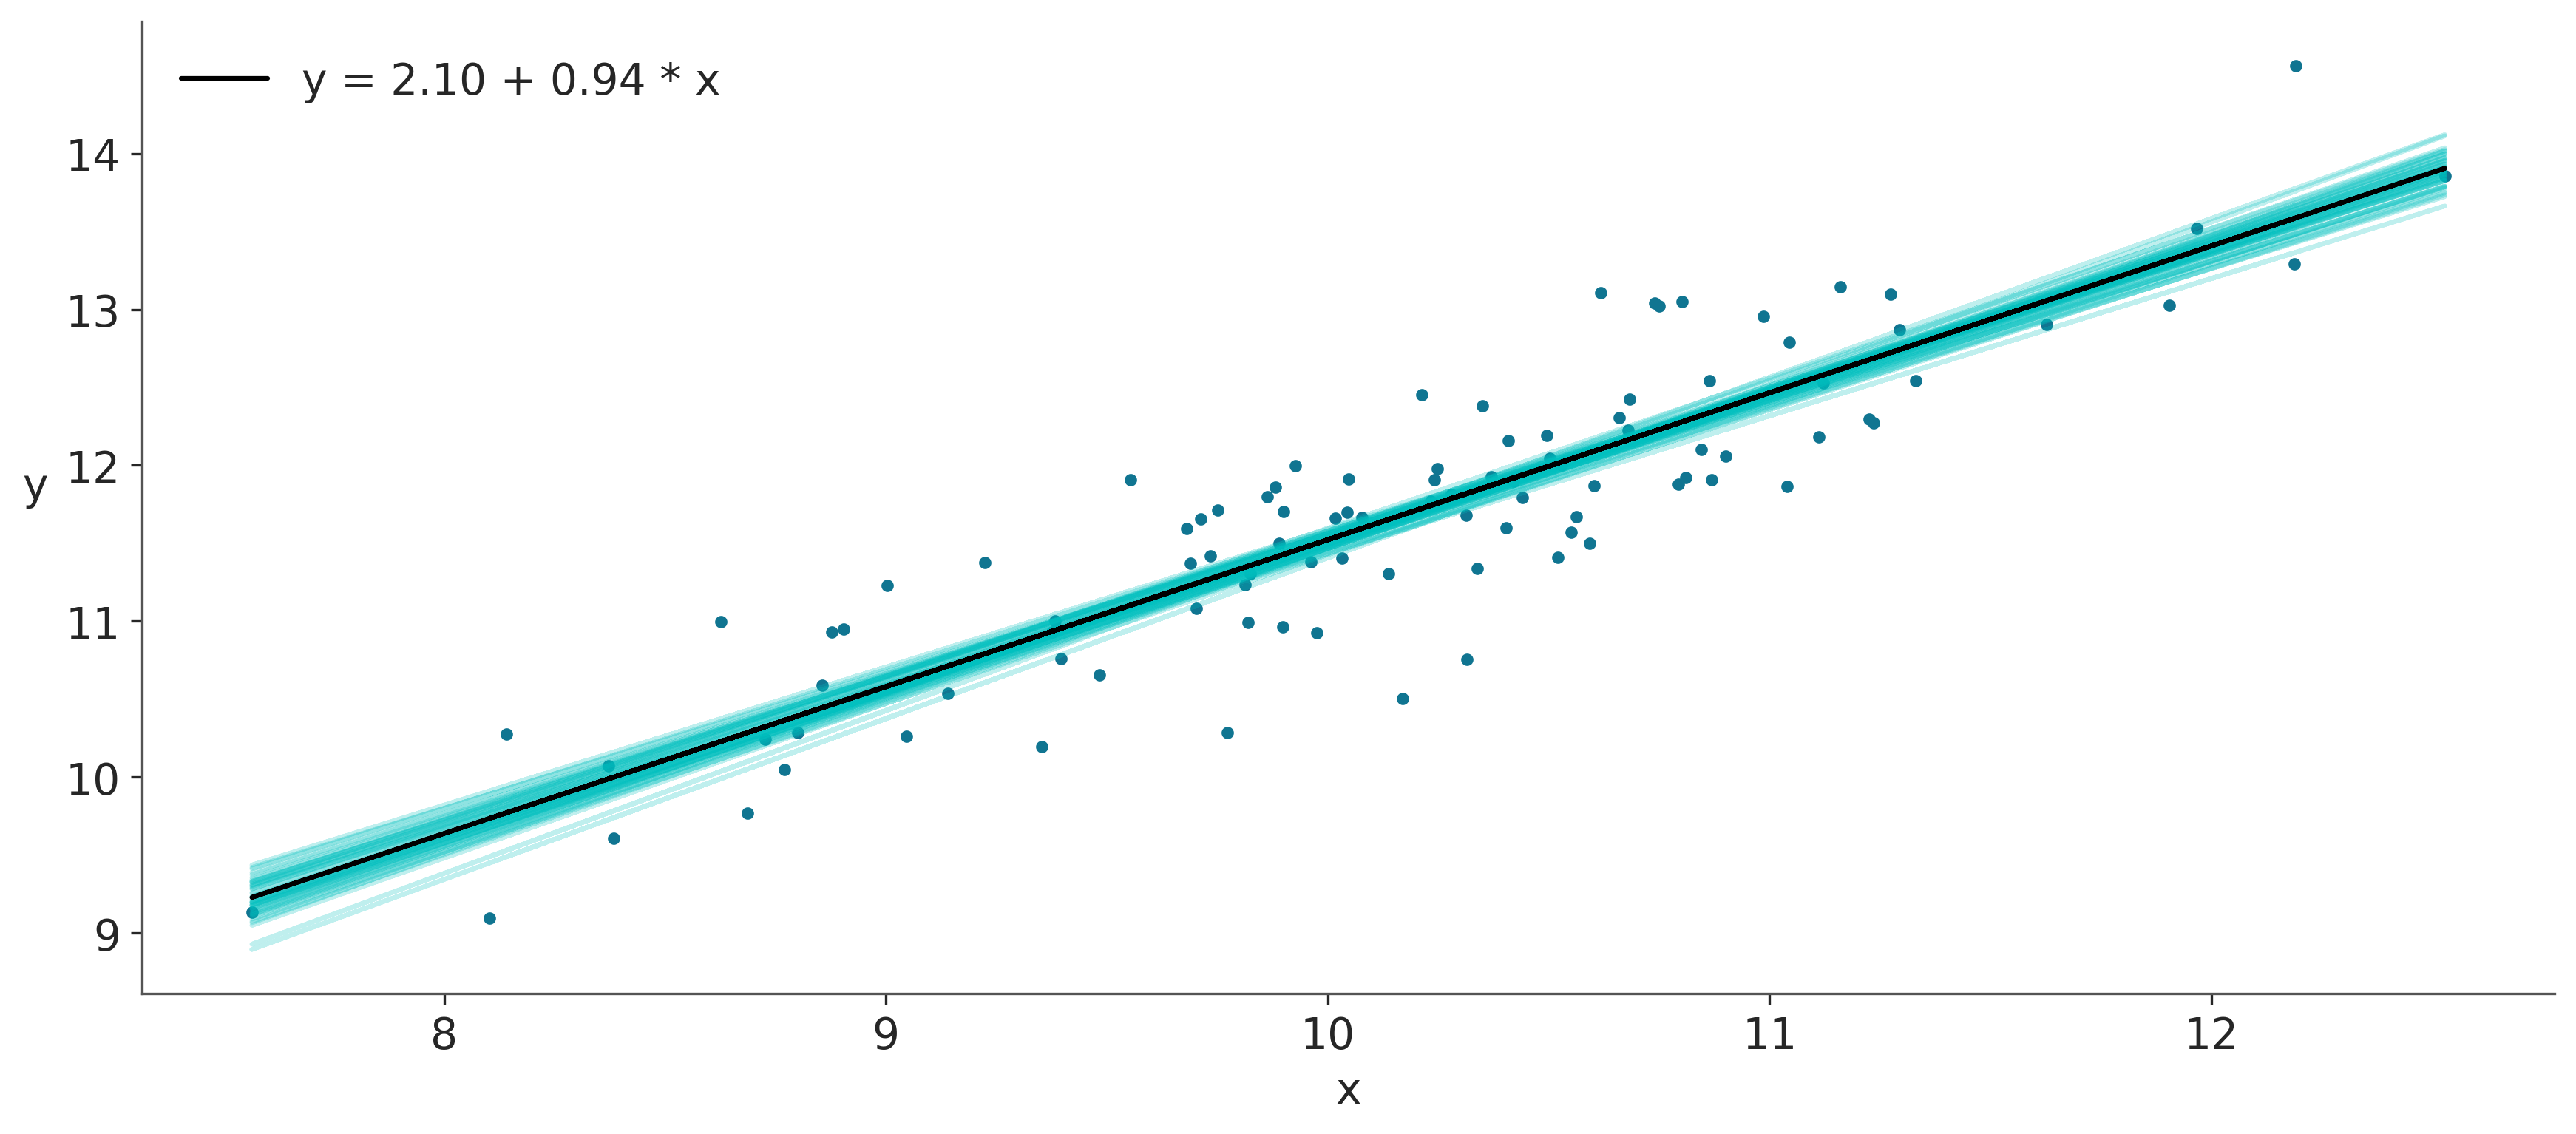

In [7]:
plt.plot(x, y, 'C0.')


α_m = idata_g.posterior['α'].mean(("chain", "draw")).item()
β_m = idata_g.posterior['β'].mean(("chain", "draw")).item()

few_samples = az.extract(idata_g, num_samples=50)
plt.plot(x, few_samples['α'].values + few_samples['β'].values *  x[:,np.newaxis], c='C1', alpha=0.25);

plt.plot(x, α_m + β_m * x, c='k',
         label=f'y = {α_m:.2f} + {β_m:.2f} * x')

plt.xlabel('x')
plt.ylabel('y', rotation=0, labelpad=10)
plt.legend();

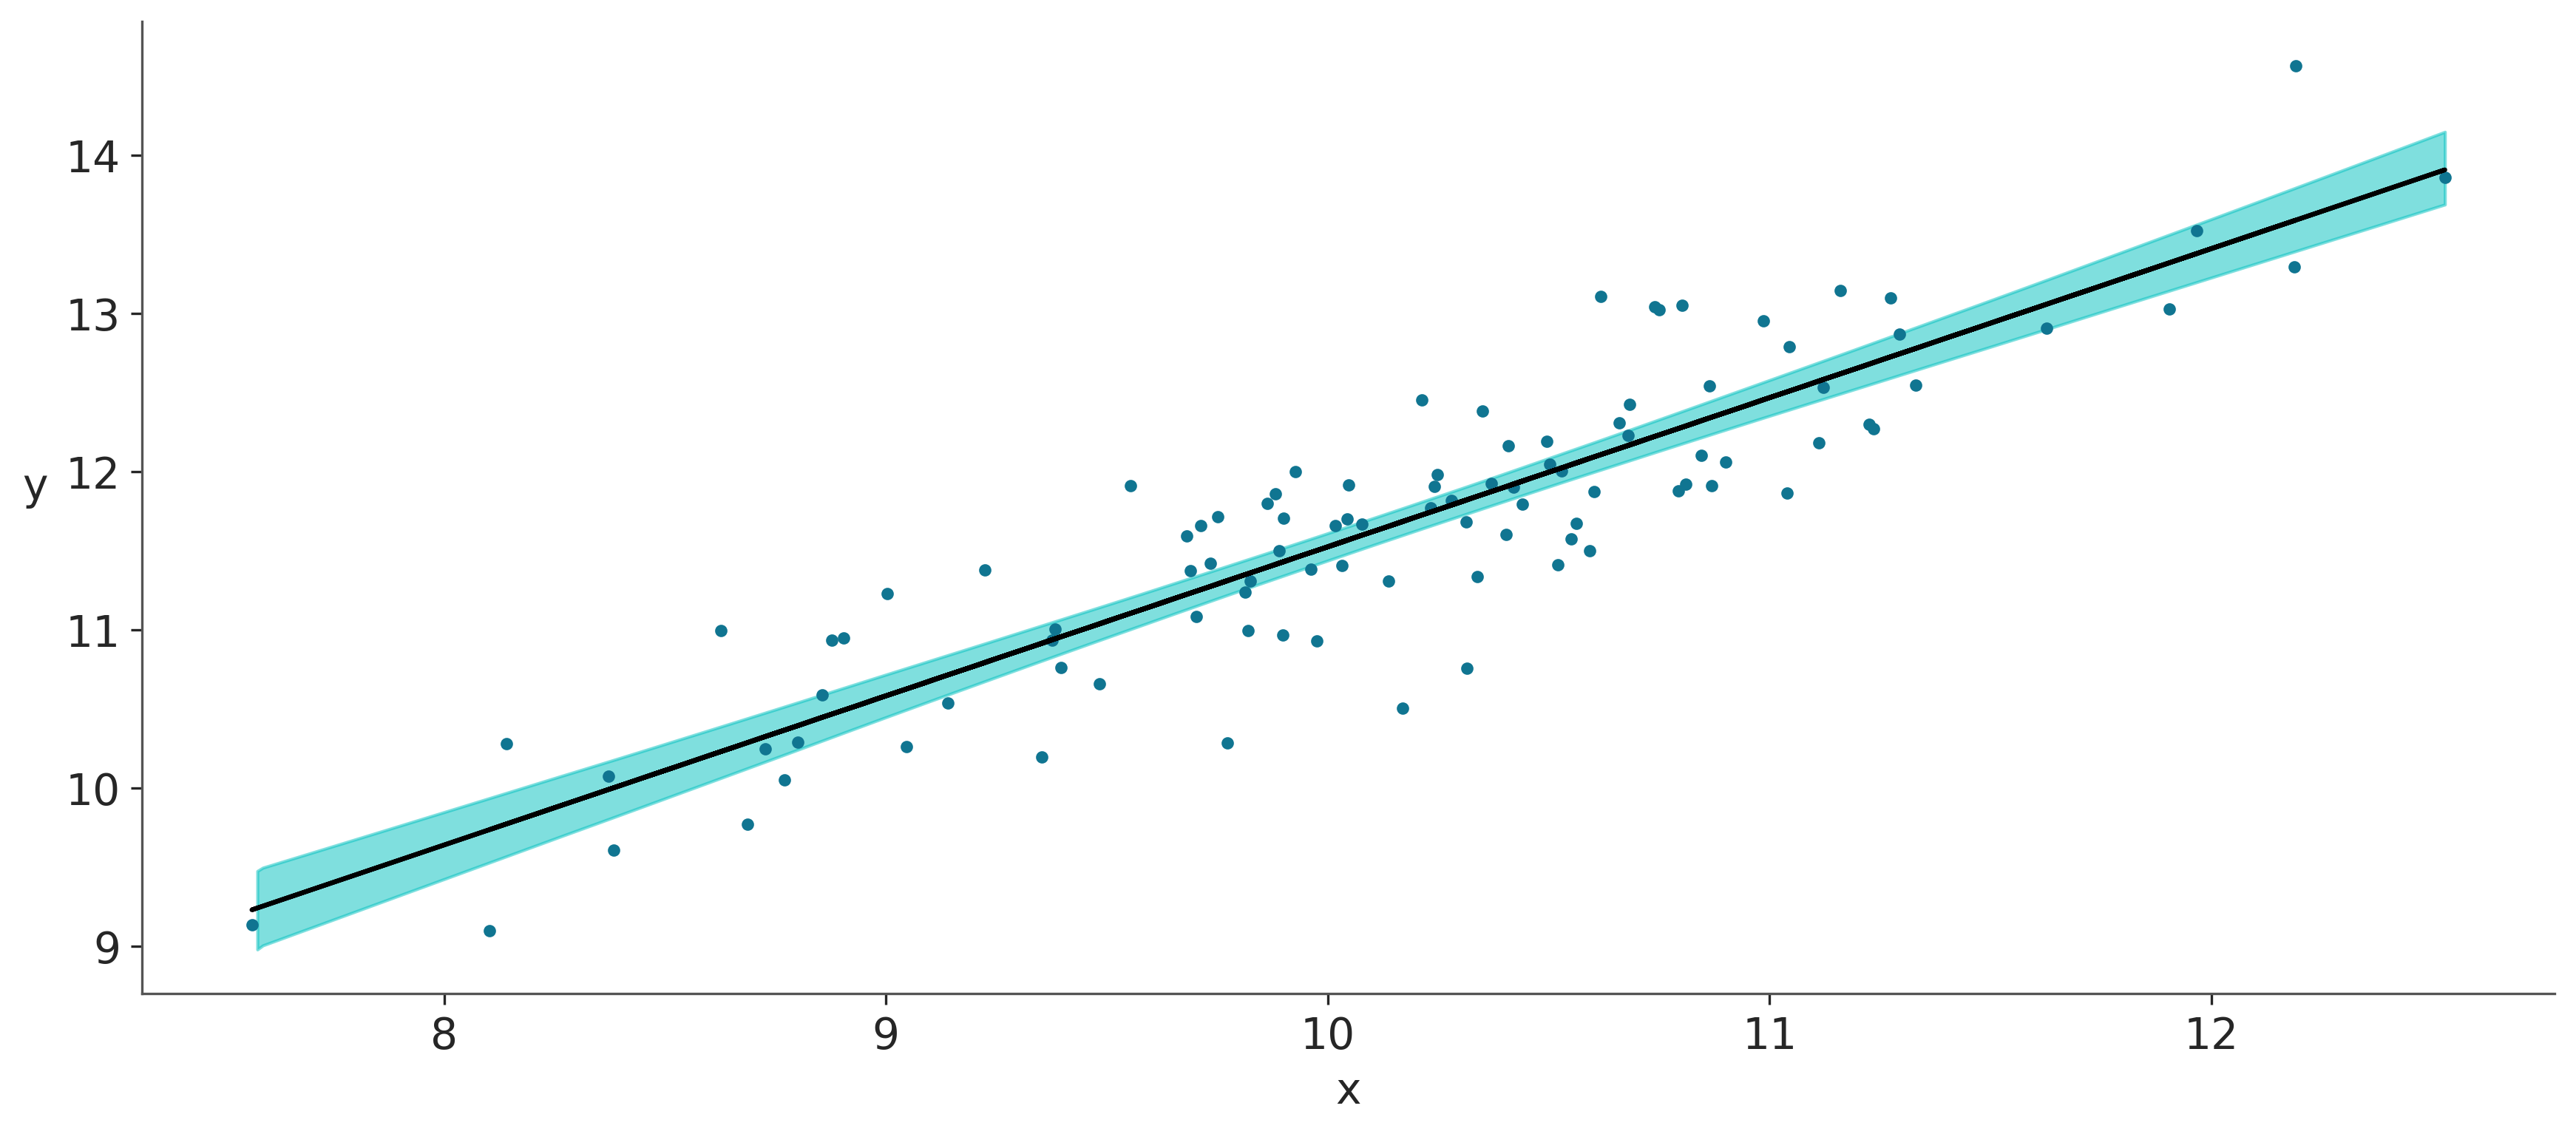

In [8]:
plt.plot(x, y, 'C0.')

plt.plot(x, α_m + β_m * x, c='k',
         label='y = {:.2f} + {:.2f} * x'.format(α_m, β_m))

az.plot_hdi(x, idata_g.posterior['μ'], color='C1')

plt.xlabel('x')
plt.ylabel('y', rotation=0, labelpad=10);

In [9]:
ppc = pm.sample_posterior_predictive(idata_g, model=model_g)

Sampling: [y_pred]


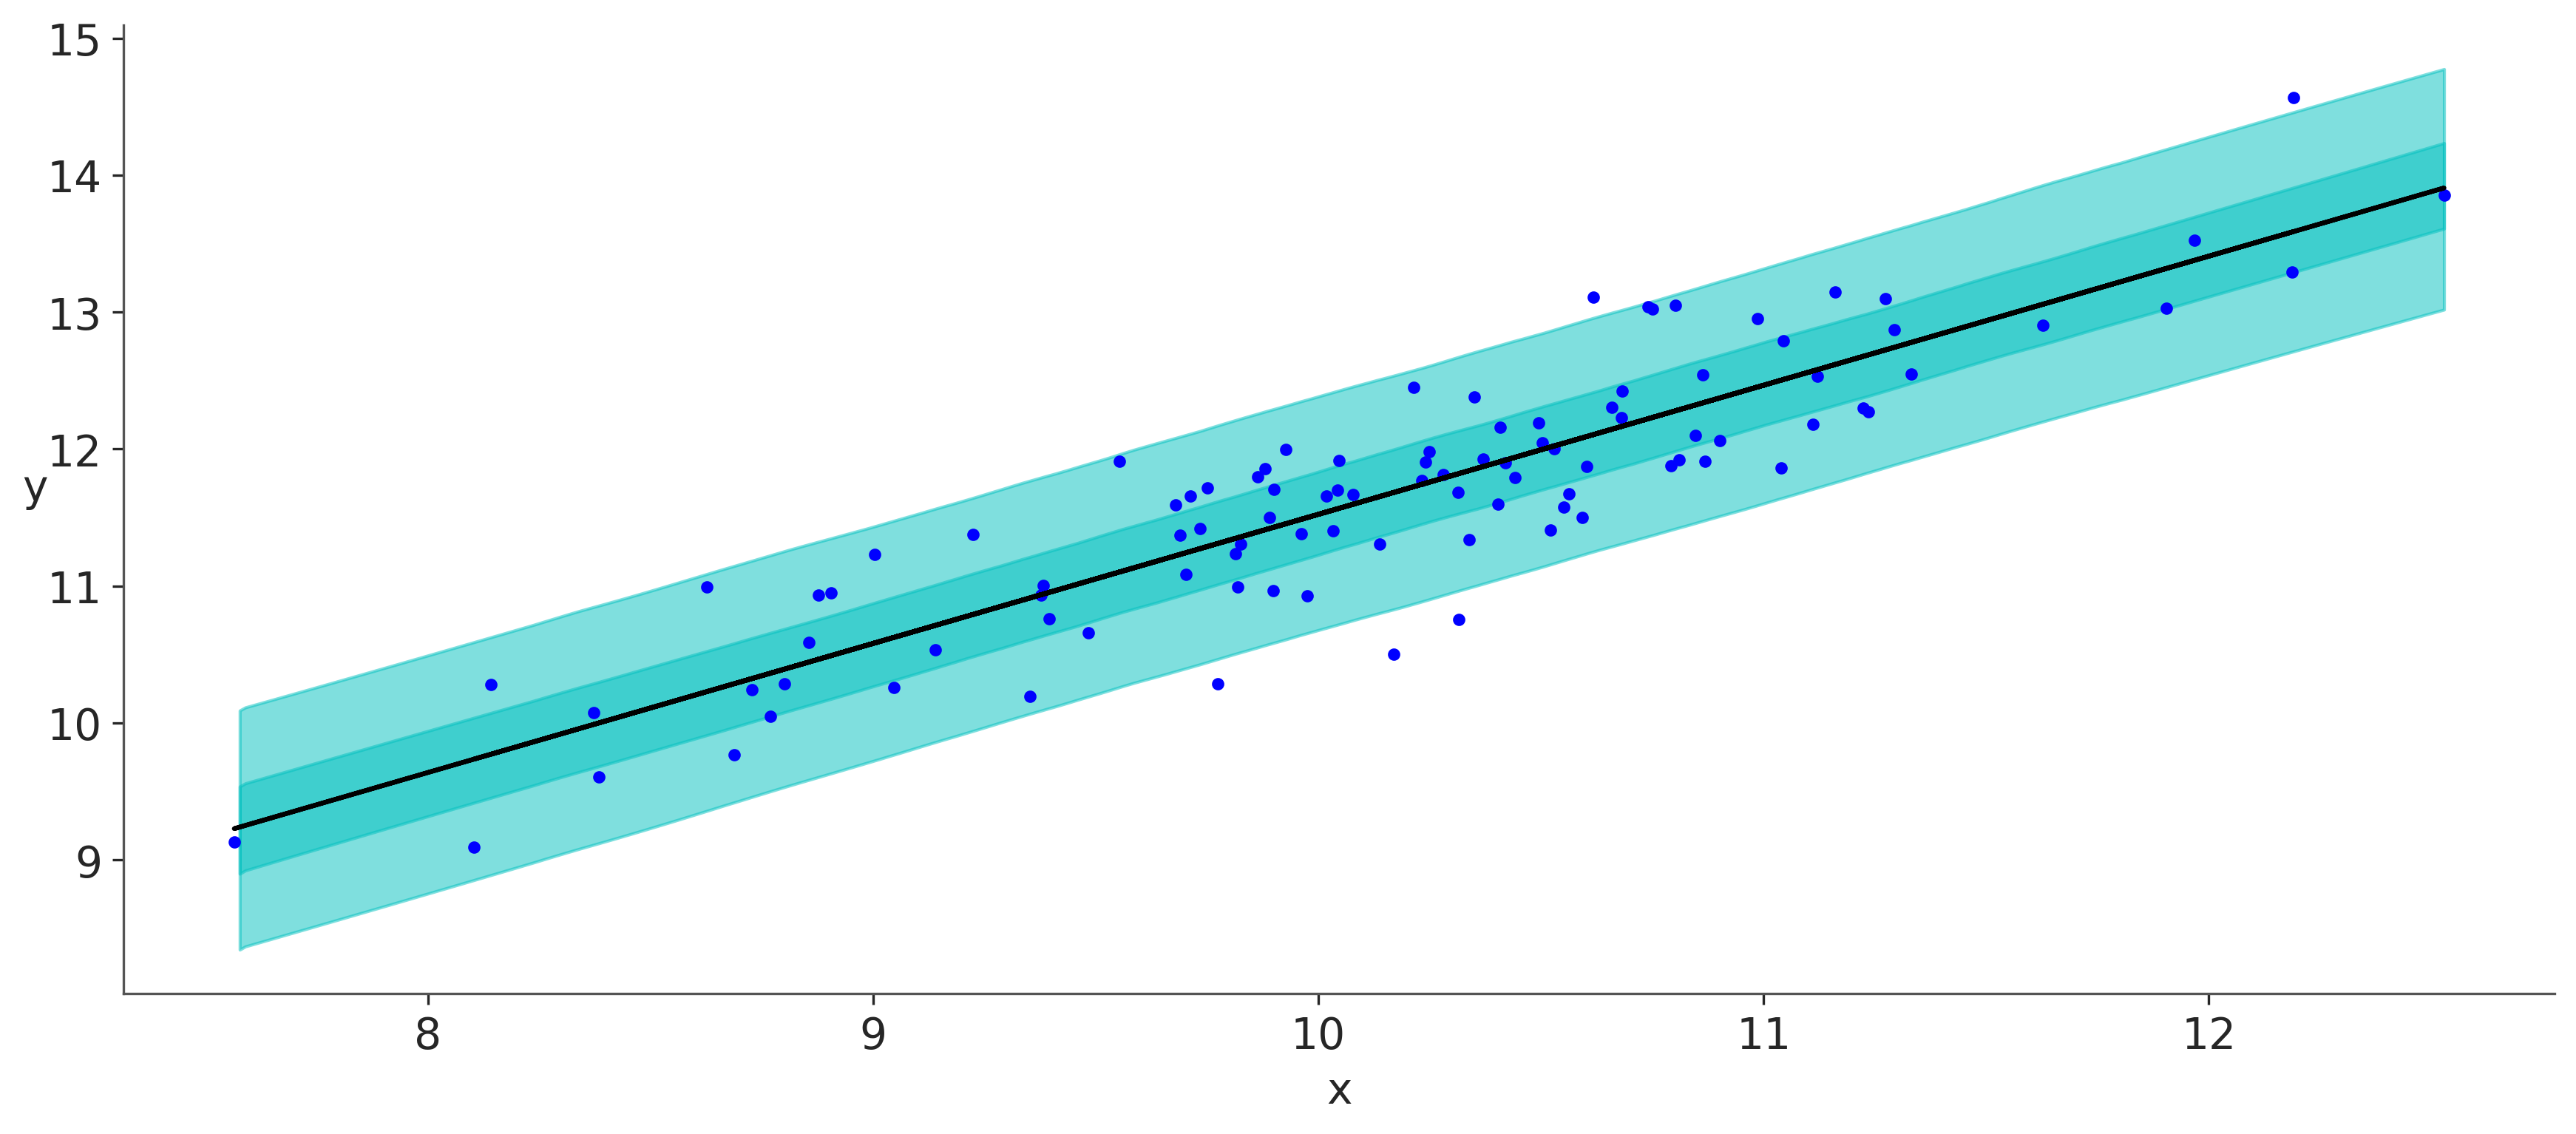

In [10]:
plt.plot(x, y, 'b.')
plt.plot(x, α_m + β_m * x, c='k', label='y = {:.2f} + {:.2f} * x'.format(α_m, β_m))

az.plot_hdi(x, ppc.posterior_predictive['y_pred'], color='C1')
az.plot_hdi(x, ppc.posterior_predictive['y_pred'], hdi_prob=0.5, color='C1')

plt.xlabel('x')
plt.ylabel('y', rotation=0);

## Centrado y estandarizado de datos


* Al trabajar con modelos de regresión (lineal) es común centrar las variables independientes (x - x.mean())
    * Ayuda con la interpretación $\alpha$ el valor de y --> cuando $\bar x$
    * Ayuda a elegir priors, $\alpha$ será un valor cercano a 0
    * Puede ayudar con el muestreo


* Al trabajar con modelos de regresión (lineal) es común estandarizar las variables (x - x.mean() / x.std(), y - y.mean() / y.std())
    * Ayuda con la interpretación $\beta$ está en término de unidades estándar
    * Ayuda a elegir priors basados en el punto anterior

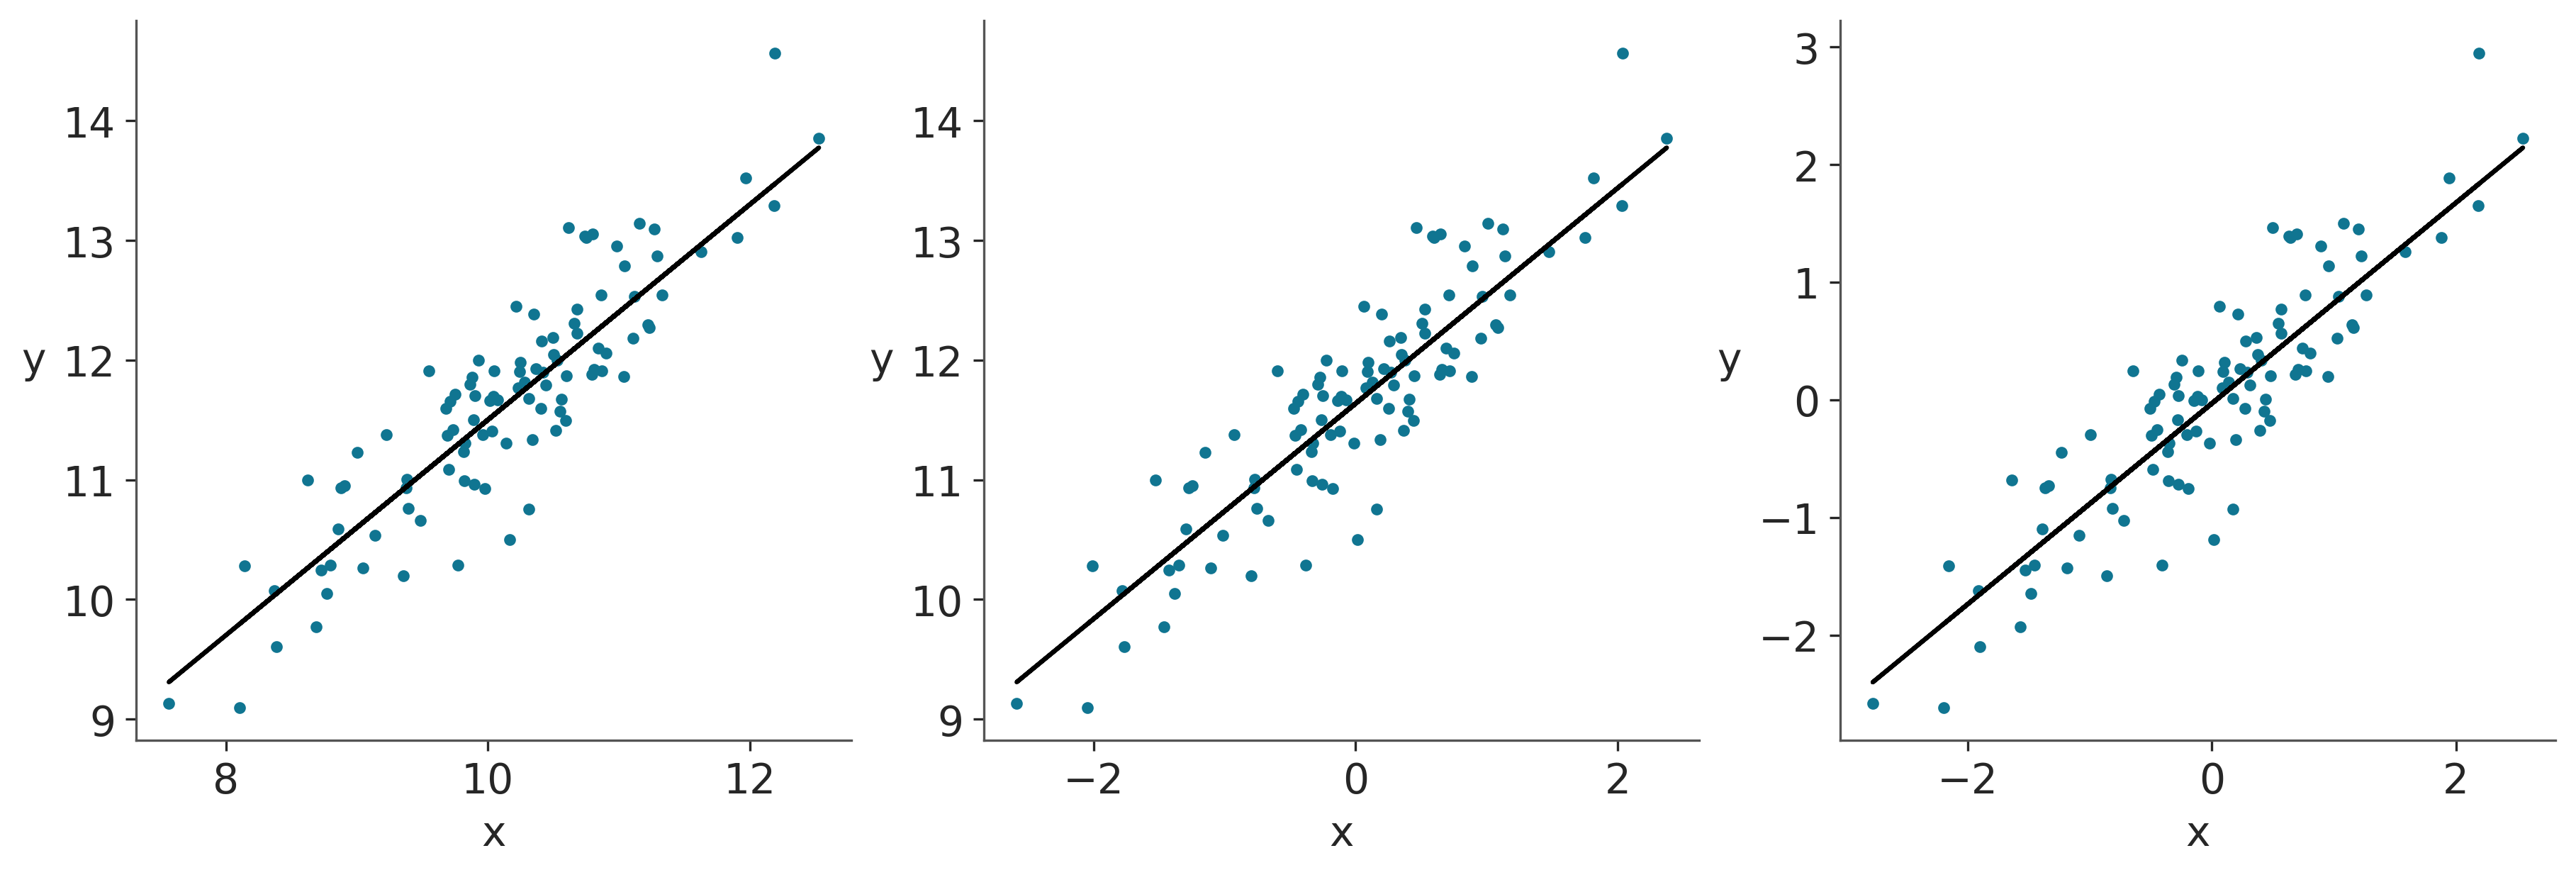

In [11]:
_, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

values = ((x, y, y_real),
         (x-x.mean(), y, y_real),
         ((x-x.mean()) / x.std(), (y-y.mean()) / y.std(), (y_real-y.mean()) / y.std()))

for ax, (x_, y_, y_real_) in zip(axes, values):
    ax.plot(x_, y_, 'C0.')
    ax.set_xlabel('x')
    ax.set_ylabel('y', rotation=0, labelpad=10)
    ax.plot(x_, y_real_, 'k')

## Regresión lineal robusta

<br>
<br>

<center><img src="../img/outlier.png" width="750">


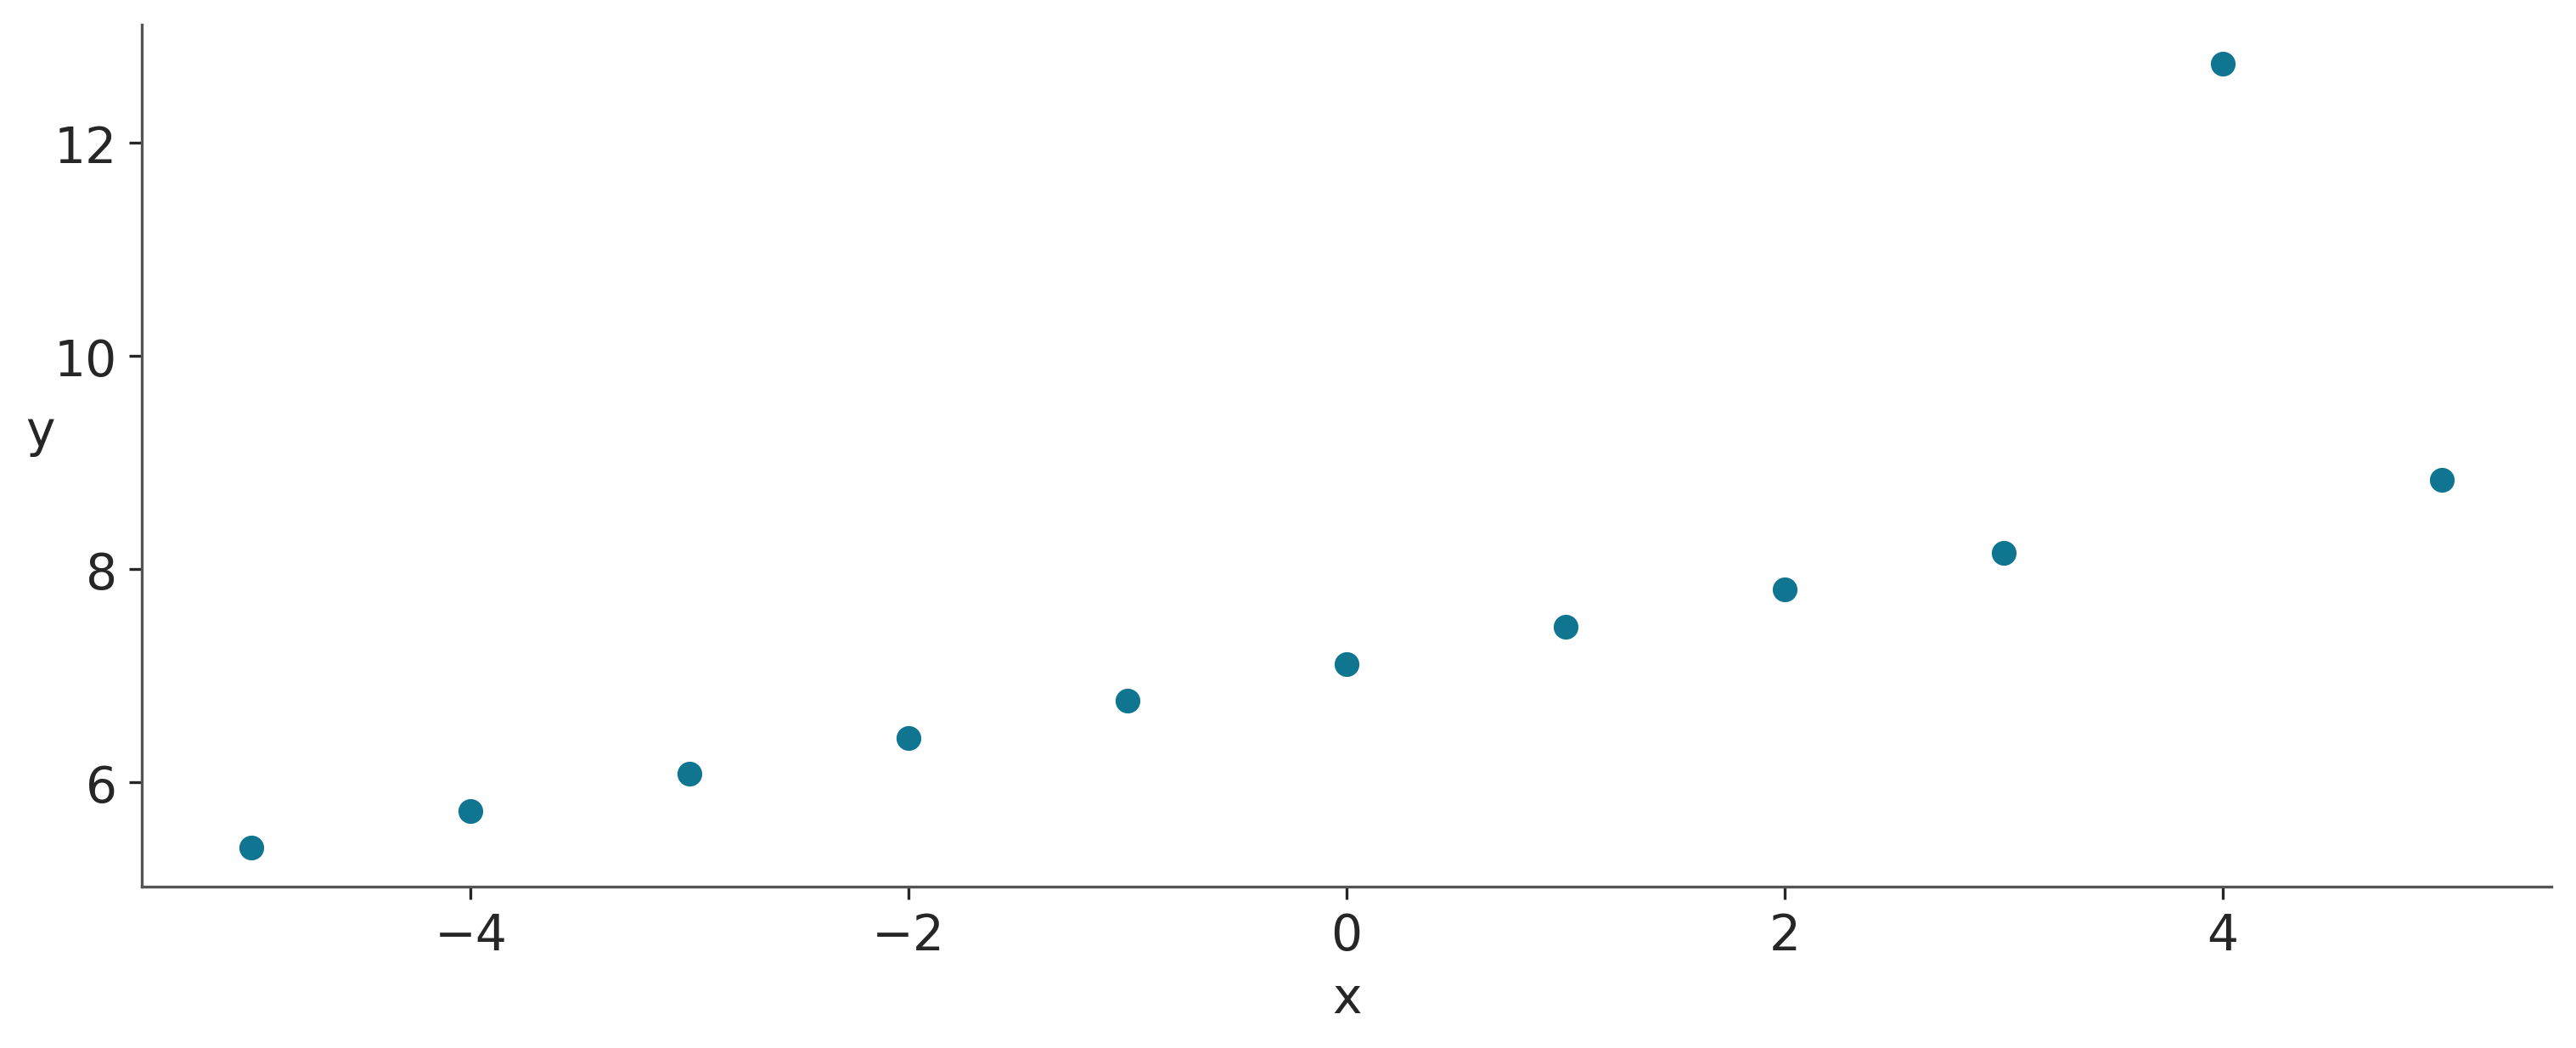

In [12]:
ans = pd.read_csv('../datos/anscombe.csv')
x_3 = ans[ans.group == 'III']['x'].values
y_3 = ans[ans.group == 'III']['y'].values
x_3 = x_3 - x_3.mean()

_, ax = plt.subplots(figsize=(10,4))

ax.plot(x_3, y_3, 'C0o')
ax.set_xlabel('x',)
ax.set_ylabel('y', rotation=0);

In [13]:
with pm.Model() as modelo_t:
    α = pm.Normal('α', mu=y_3.mean(), sigma=1)
    β = pm.Normal('β', mu=0, sigma=1)
    ϵ = pm.HalfNormal('ϵ', 5)
    ν_ = pm.Exponential('ν_', 1/29)
    ν = pm.Deterministic('ν', ν_ + 1)
    
    y_pred = pm.StudentT('y_pred', mu=α + β * x_3,
                         sigma=ϵ, nu=ν, observed=y_3)
    
    idata_t = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ϵ, ν_]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.


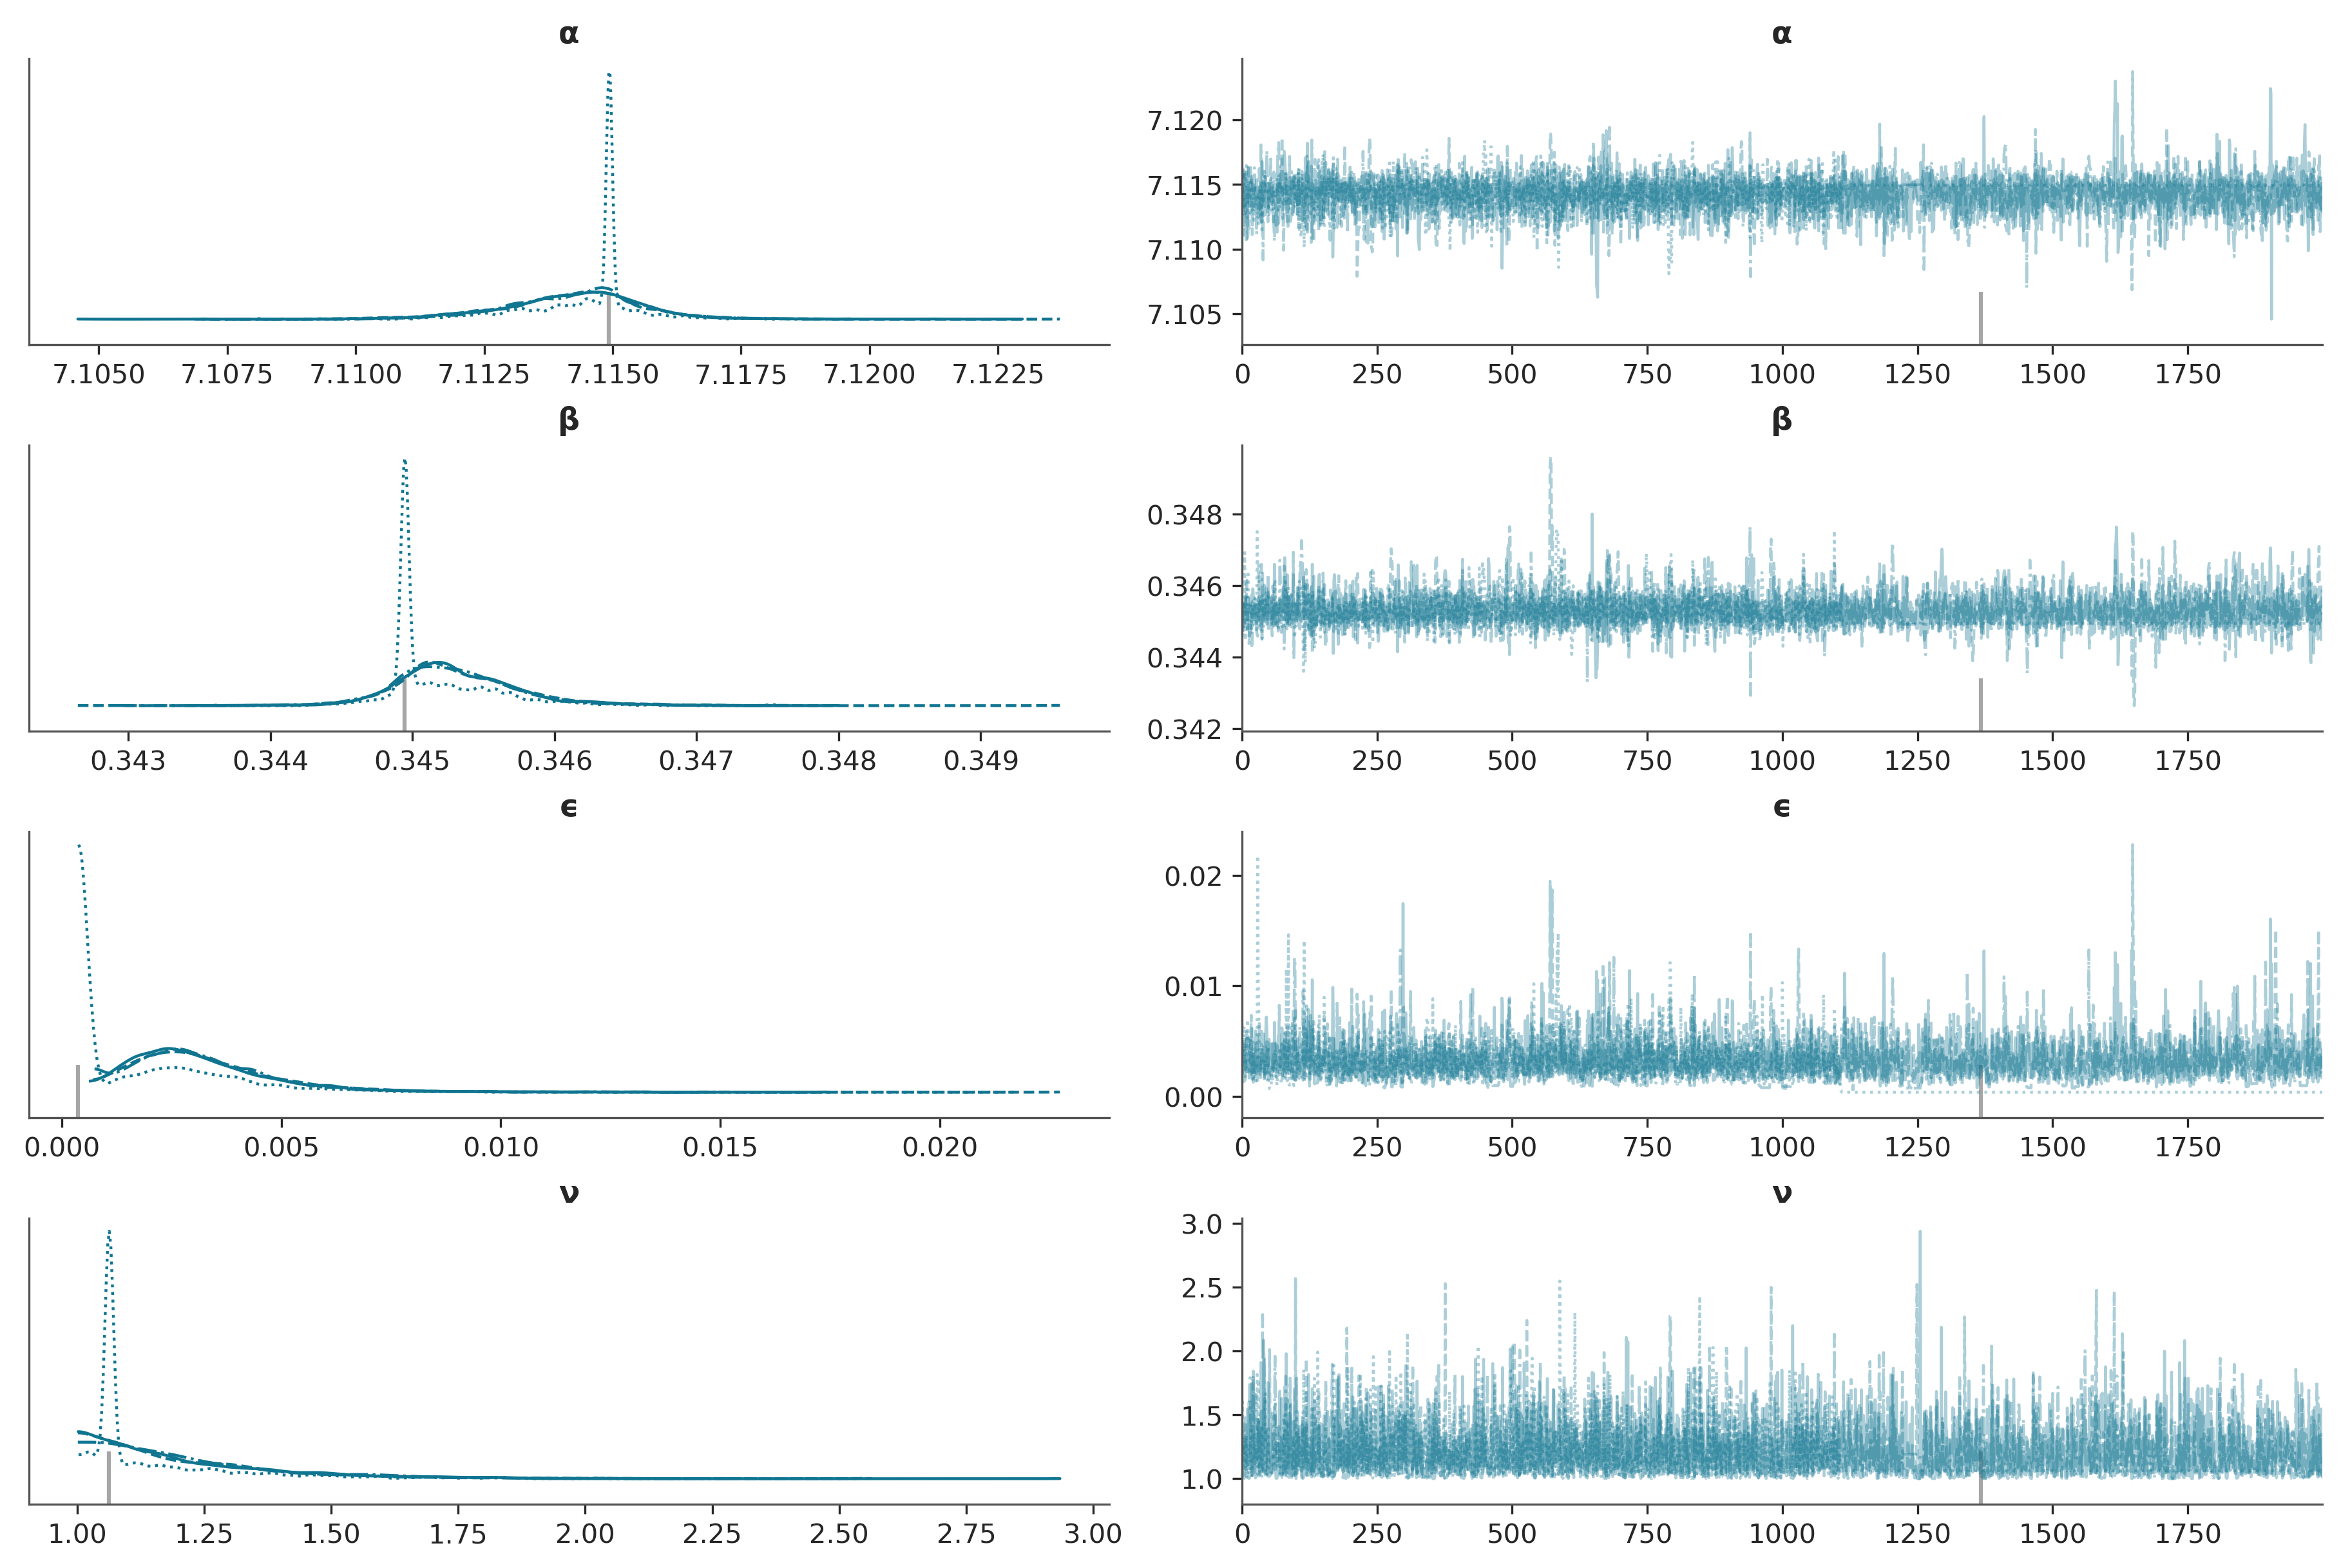

In [14]:
az.plot_trace(idata_t, var_names='~ν_');

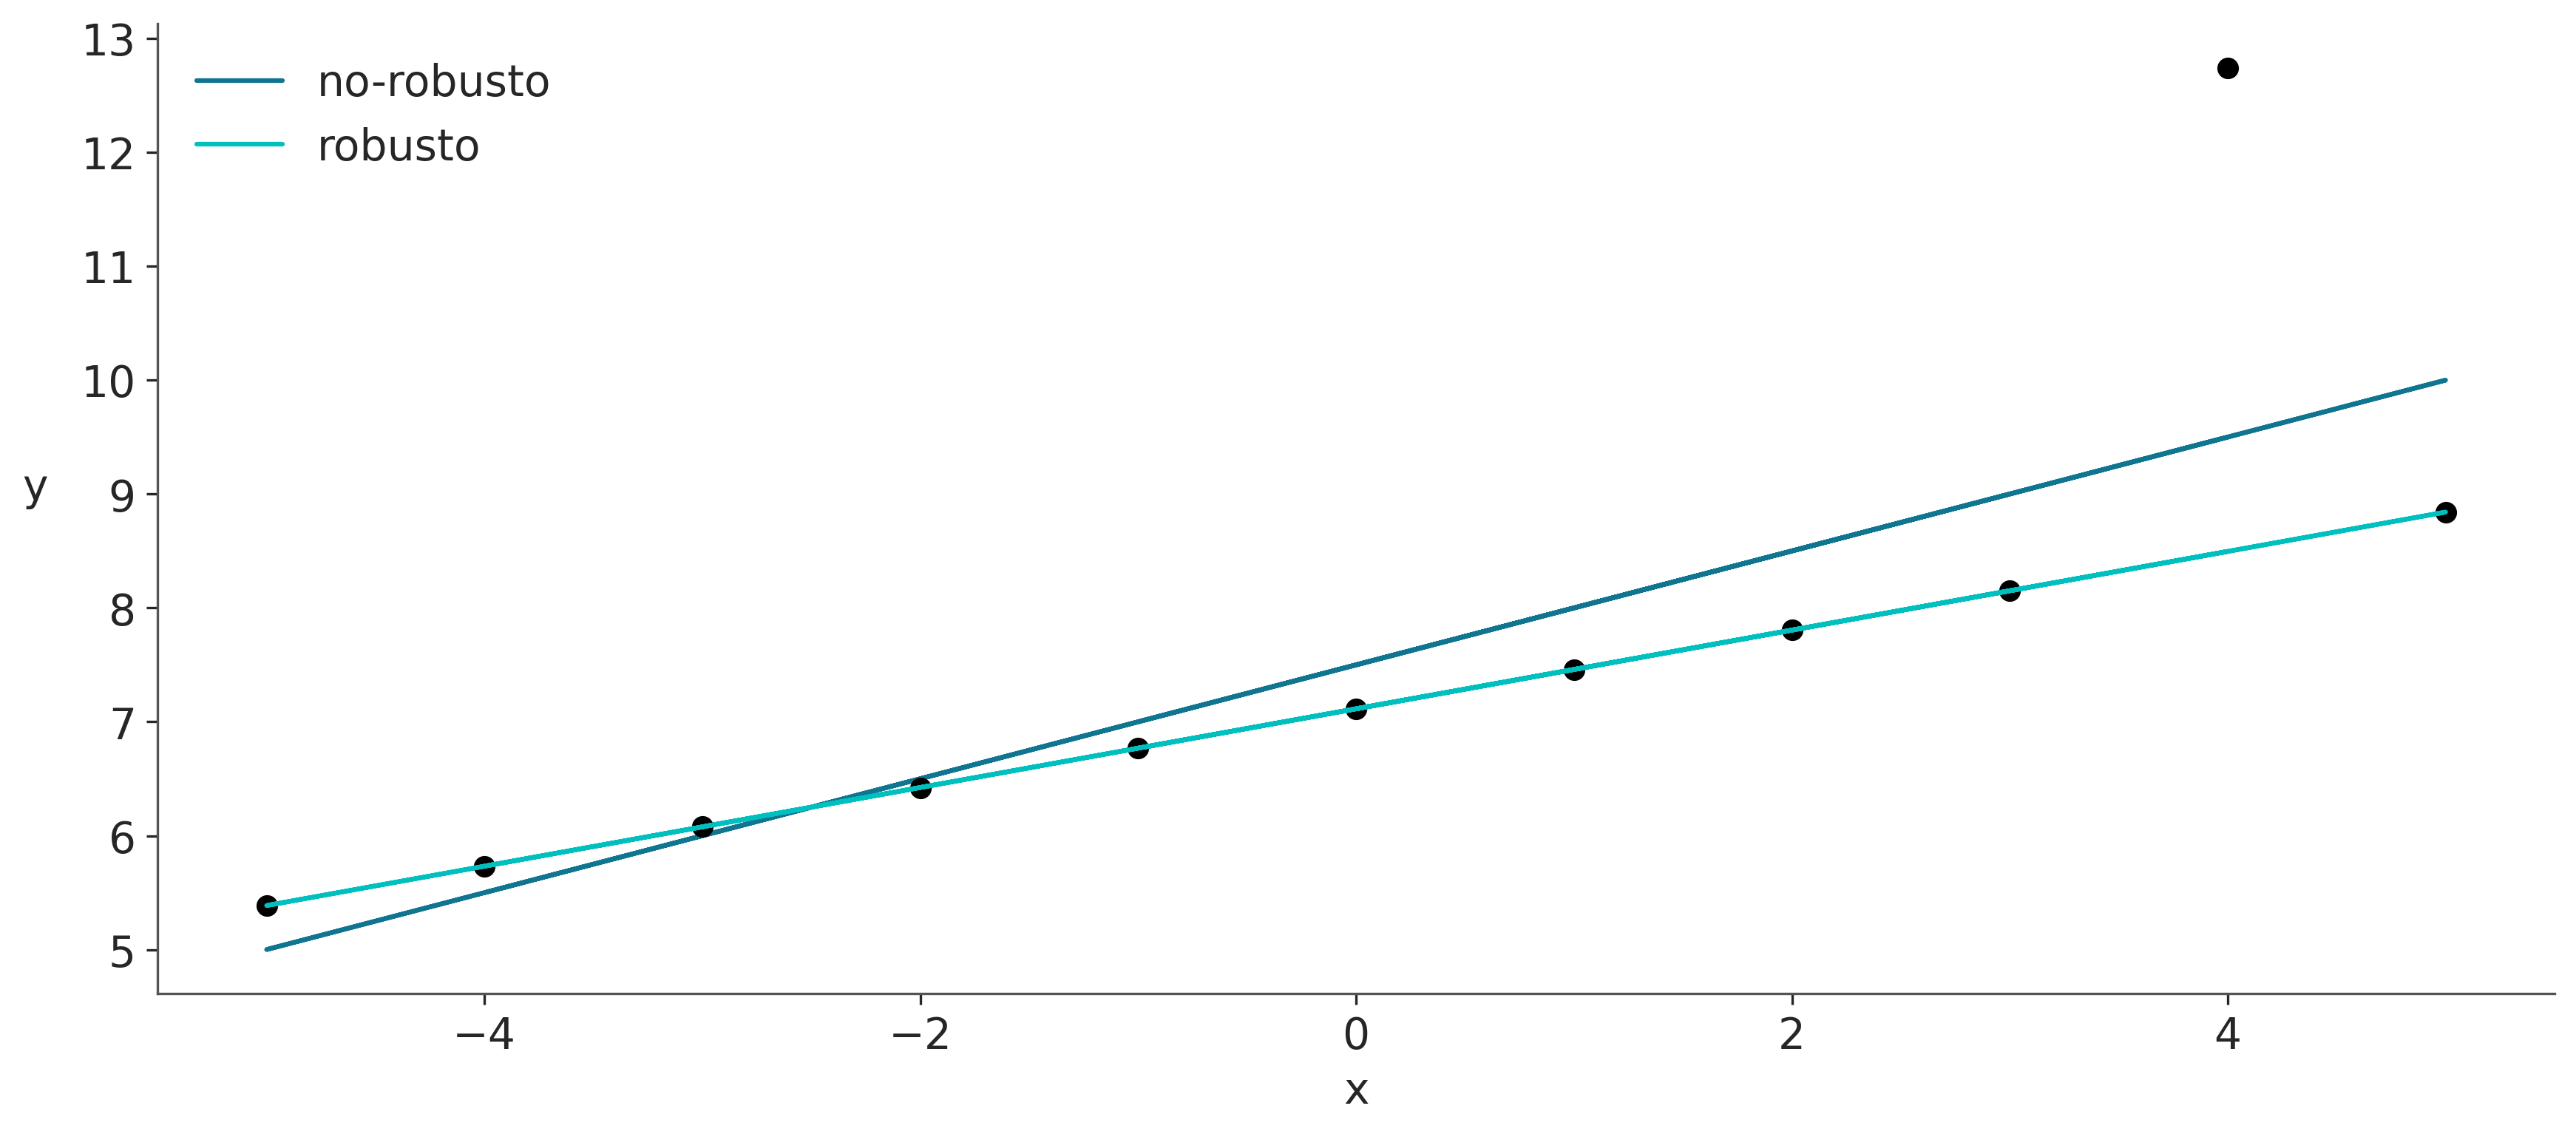

In [15]:
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]

plt.plot(x_3, (alpha_c + beta_c * x_3), label='no-robusto')
plt.plot(x_3, y_3, 'ko')
alpha_m = idata_t.posterior['α'].mean().item()
beta_m = idata_t.posterior['β'].mean().item()
plt.plot(x_3, alpha_m + beta_m * x_3, label='robusto')

plt.xlabel('x')
plt.ylabel('y', rotation=0, labelpad=15)
plt.legend(loc=2);

In [16]:
az.summary(idata_t, var_names='~ν_')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,7.114,0.001,7.111,7.116,0.000,0.000,307.0,3653.0,1.02
β,0.345,0.000,0.345,0.346,0.000,0.000,60.0,3009.0,1.05
ϵ,0.003,0.002,0.000,0.006,0.000,0.000,13.0,4159.0,1.22
ν,1.191,0.193,1.000,1.553,0.018,0.013,148.0,2518.0,1.02


## Regresión lineal jerárquica


* Podemos crear modelos lineales jerárquicos


* El escenario más común quizá sea un valor de $\alpha$, $\beta$ por grupo y un valor de $\sigma$ común para todos los grupos


* En el siguiente ejemplo tenemos 8 grupos, uno de ellos con un solo dato!

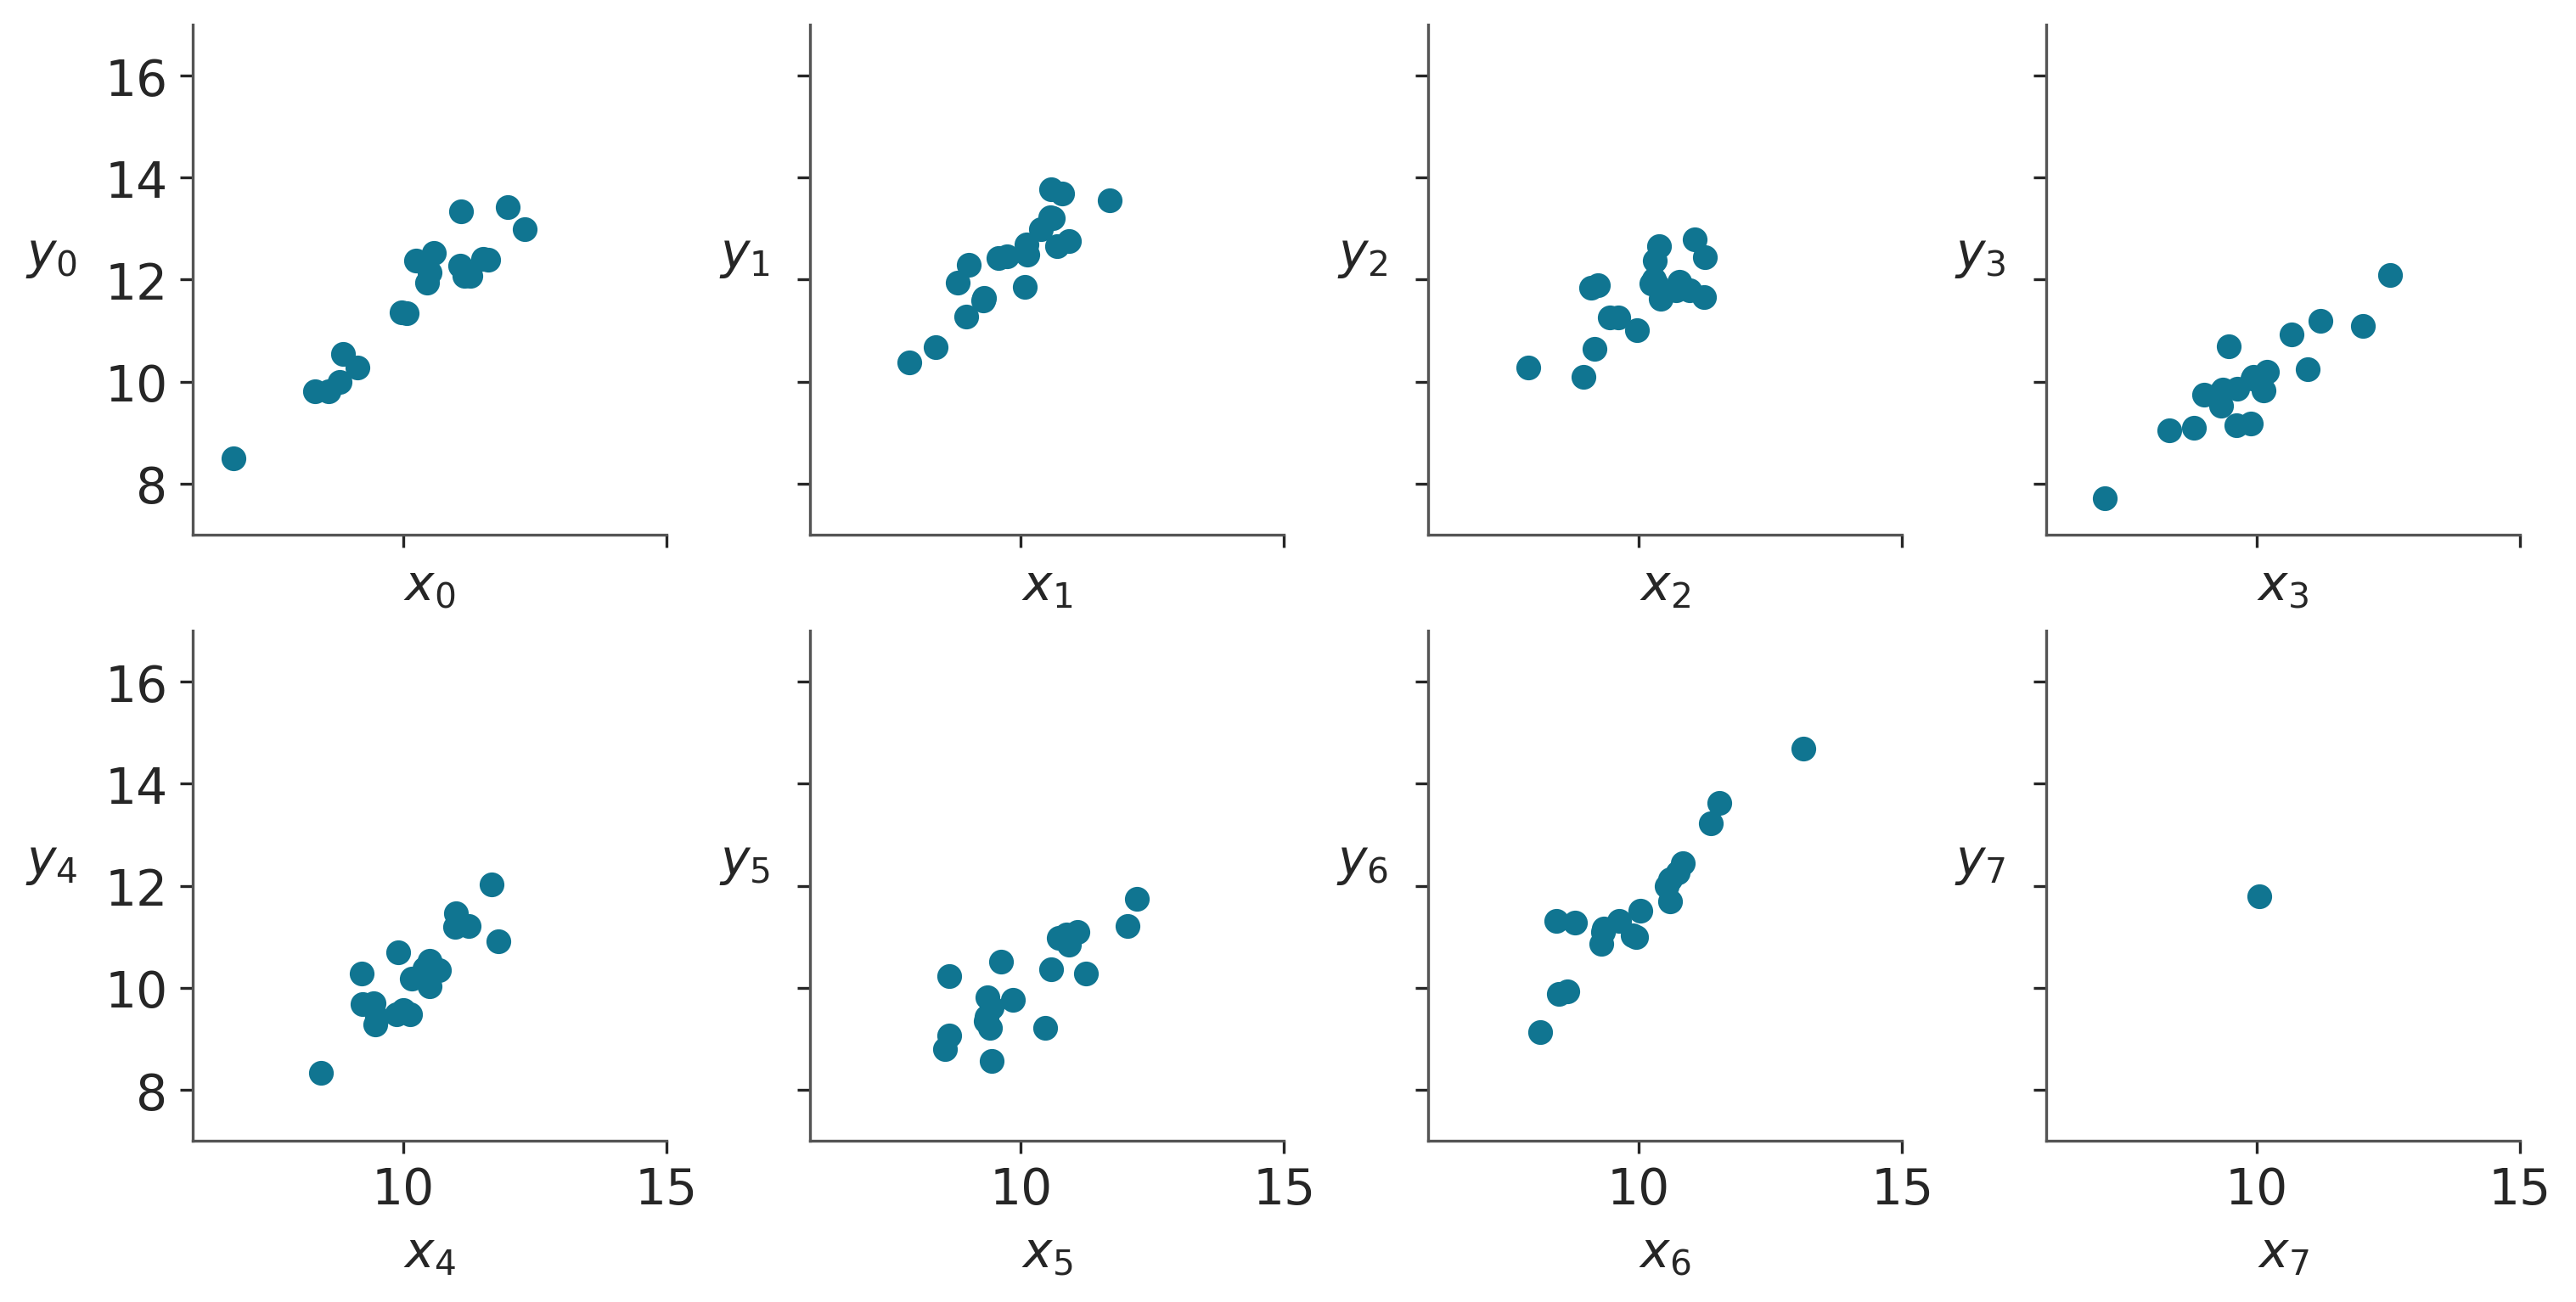

In [17]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)
np.random.seed(314)

alfa_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alfa_real[idx] + beta_real[idx] * x_m  + eps_real

_, ax = plt.subplots(2, 4, figsize=(10,5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel('$x_{}$'.format(i))
    ax[i].set_ylabel('$y_{}$'.format(i), rotation=0, labelpad=15)
    ax[i].set_xlim(6, 15)
    ax[i].set_ylim(7, 17)
    j += N
    k += N

In [18]:
x_centered = x_m - x_m.mean()

In [19]:
with pm.Model() as hierarchical_model:
    # hyper-priors
    α_μ = pm.Normal('α_μ', mu=0, sigma=10)
    α_σ = pm.HalfNormal('α_σ', 10)
    β_μ = pm.Normal('β_μ', mu=0, sigma=10)
    β_σ = pm.HalfNormal('β_σ', sigma=10)

    # priors
    α_tmp = pm.Normal('α_tmp', mu=α_μ, sigma=α_σ, shape=M)
    β = pm.Normal('β', mu=β_μ, sigma=β_σ, shape=M)
    ϵ = pm.HalfNormal('ϵ', 10)
    ν = pm.Exponential('ν', 1/30)

    y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered,
                         sigma=ϵ, nu=ν, observed=y_m)

    α = pm.Deterministic('α', α_tmp - β * x_m.mean()) 
    
    idata_hm = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_μ, α_σ, β_μ, β_σ, α_tmp, β, ϵ, ν]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


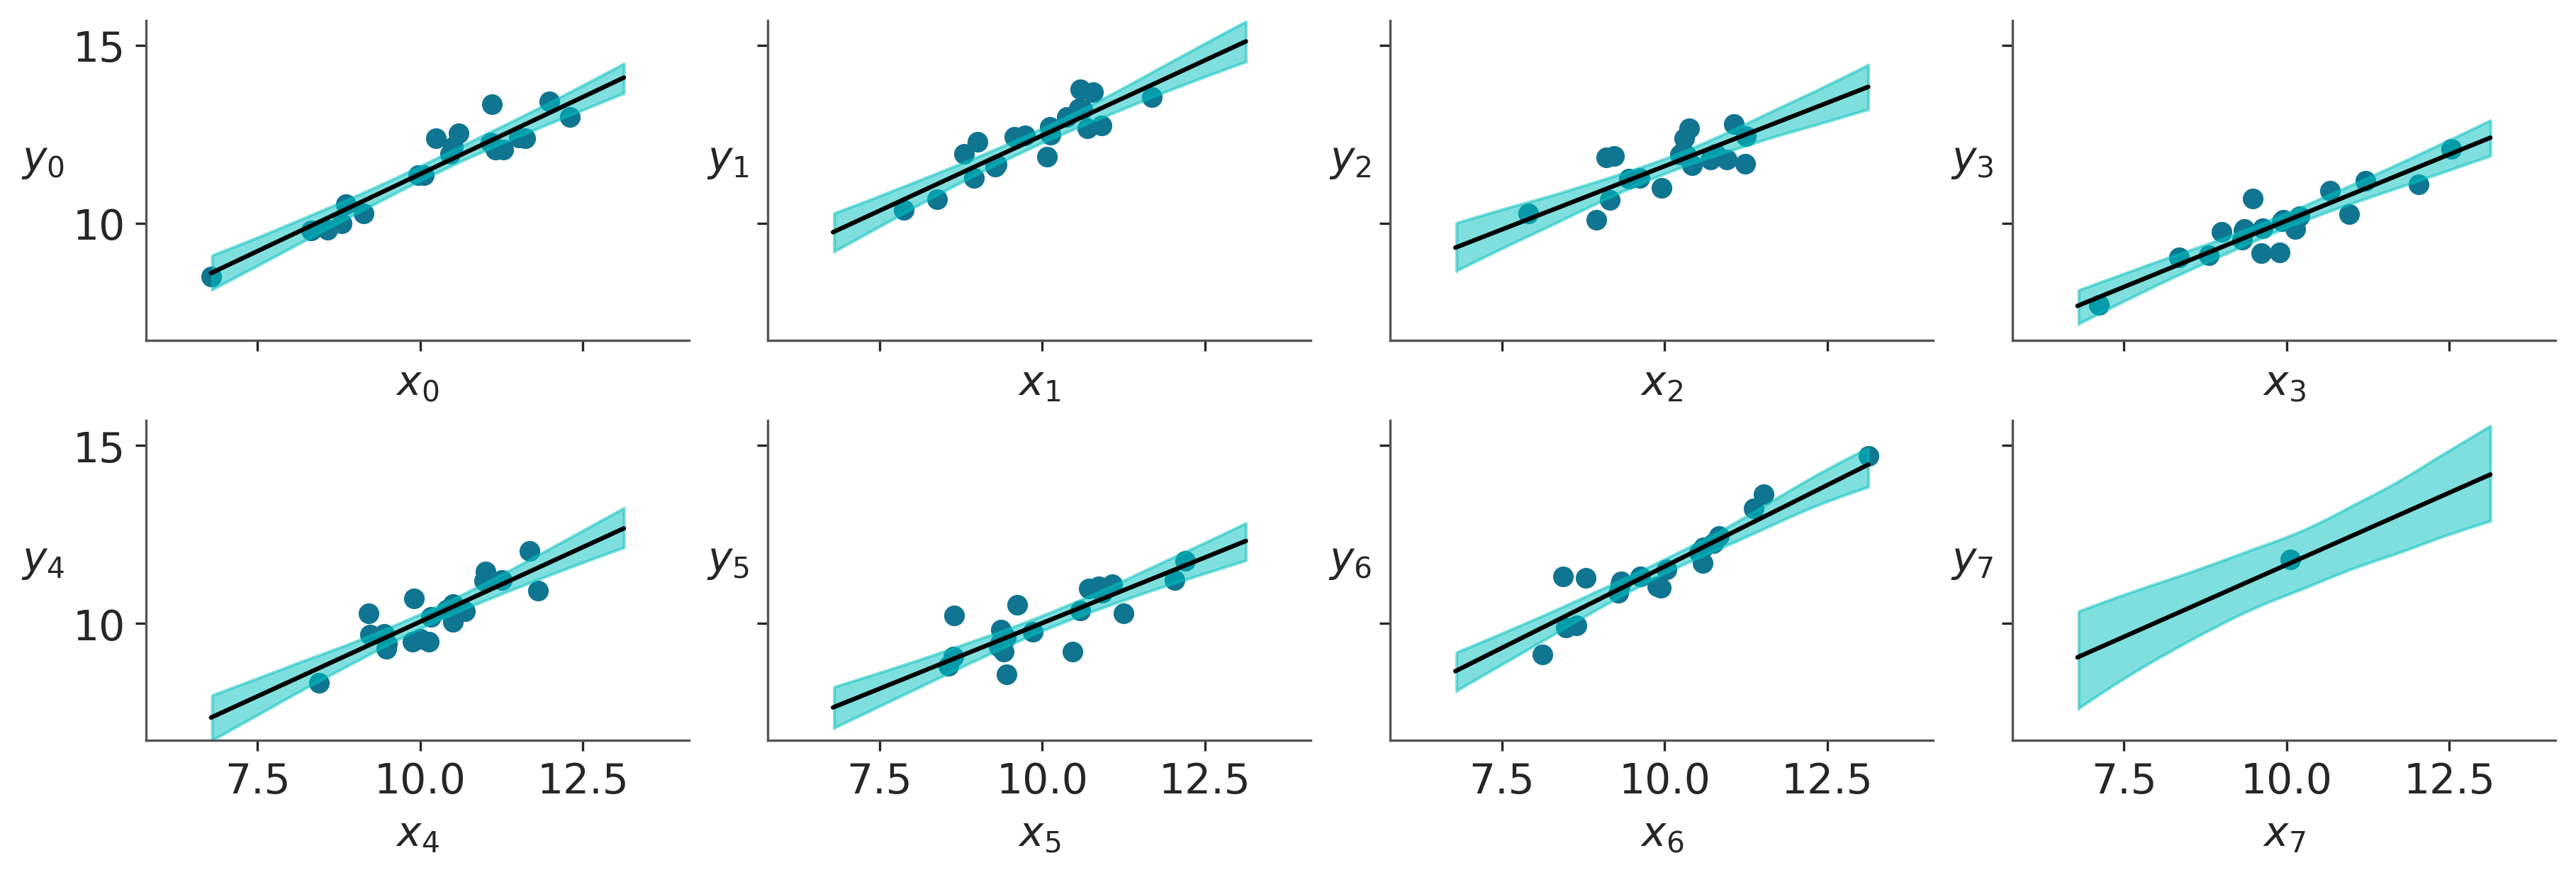

In [20]:
_, ax = plt.subplots(2, 4, figsize=(12, 4), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
posterior = az.extract(idata_hm)

for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel('$x_{}$'.format(i))
    ax[i].set_ylabel('$y_{}$'.format(i), labelpad=10, rotation=0)
    alfas = posterior['α'].sel(α_dim_0=i)
    betas = posterior['β'].sel(β_dim_0=i)
    alfa_m = alfas.mean("sample").item()
    beta_m = betas.mean("sample").item()
    ax[i].plot(x_range, alfa_m + beta_m * x_range, c='k')
    az.plot_hdi(x_range, alfas + betas * xr.DataArray(x_range).transpose(), ax=ax[i])
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N

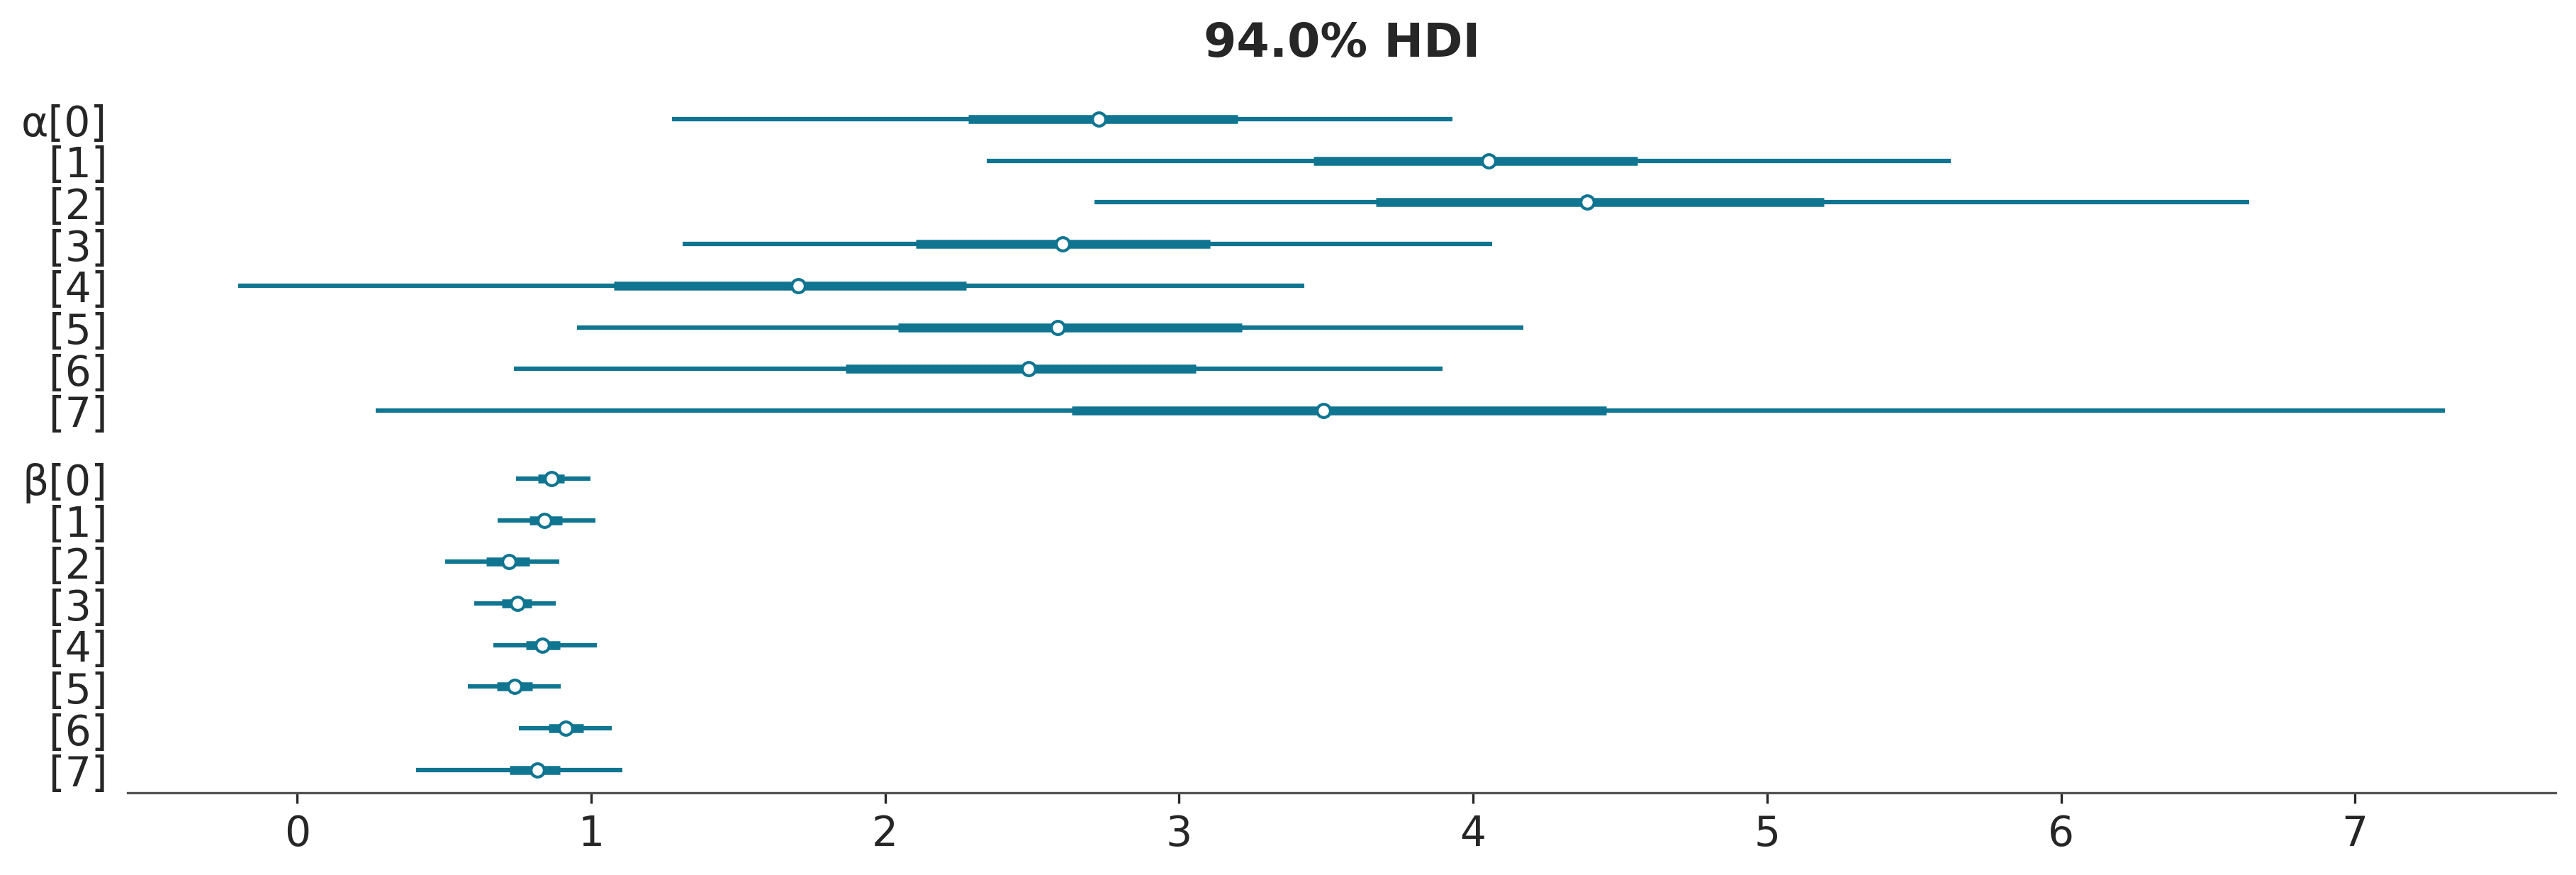

In [21]:
az.plot_forest(idata_hm, var_names=['α', 'β'], figsize=(12, 4), combined=True, r_hat=False, ess=False);